<a href="https://colab.research.google.com/github/proxOP/Market-Regime-Clustering/blob/main/RozReturns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task@RozReturns
##Problem Statement :: Regime Detection via Unsupervised Learning from Order Book and Volume Data


##🧠 Overview
###In this project, we aim to identify distinct market regimes using unsupervised learning techniques. A market regime refers to a prevailing condition of market behavior. These regimes are influenced by multiple microstructural factors and can change over time, impacting trading strategies and risk models.

Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



To begin our analysis, we load the necessary market data files:

Order Book Data (depth20_1000ms/) — Contains snapshots of Level 20 bid/ask data at 1-second intervals.

Aggregated Trade Data (aggTrade/) — Contains information about executed trades over time.

In [2]:

base_path = '/content/drive/MyDrive/'
depth_folder = base_path + 'depth20_1000ms/'
trade_folder = base_path + 'aggTrade/'


import os
print("Order book files:")
print(os.listdir(depth_folder))
print("\nTrade files:")
print(os.listdir(trade_folder))

Order book files:
['BNBFDUSD_20250317.txt', 'BNBFDUSD_20250315.txt', 'BNBFDUSD_20250314.txt', 'BNBFDUSD_20250316.txt', 'BNBFDUSD_20250314_features.csv', 'BNBFDUSD_20250314_features_rolling.csv', 'BNBFDUSD_20250314_labeled.csv', 'BNBFDUSD_20250315_features.csv', 'BNBFDUSD_20250315_features_rolling.csv', 'BNBFDUSD_20250315_labeled.csv', 'BNBFDUSD_20250316_features.csv', 'BNBFDUSD_20250316_features_rolling.csv', 'BNBFDUSD_20250316_labeled.csv', 'BNBFDUSD_20250317_features.csv', 'BNBFDUSD_20250317_features_rolling.csv', 'BNBFDUSD_20250317_labeled.csv']

Trade files:
['BNBFDUSD_20250317.txt', 'BNBFDUSD_20250314.txt', 'BNBFDUSD_20250316.txt', 'BNBFDUSD_20250315.txt']


In [3]:
import pandas as pd
import os


base_path = '/content/drive/MyDrive/'
depth_folder = base_path + 'depth20_1000ms/'

filename = 'BNBFDUSD_20250317.txt'
file_path = os.path.join(depth_folder, filename)


df = pd.read_csv(file_path)


print("Columns:")
print(df.columns.tolist())
print("\nSample:")
print(df.head(2))


Columns:
['Time', 'BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19', 'BidPriceL18', 'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16', 'BidQtyL16', 'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14', 'BidPriceL13', 'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11', 'BidQtyL11', 'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9', 'BidPriceL8', 'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6', 'BidQtyL6', 'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4', 'BidPriceL3', 'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1', 'BidQtyL1', 'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2', 'AskPriceL3', 'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5', 'AskQtyL5', 'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7', 'AskPriceL8', 'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskPriceL10', 'AskQtyL10', 'AskPriceL11', 'AskQtyL11', 'AskPriceL12', 'AskQtyL12', 'AskPriceL13', 'AskQtyL13', 'AskPriceL14', 'AskQtyL14', 'AskPriceL15', 'AskQtyL15', 'AskPriceL16', 'AskQtyL16', 'AskPriceL

Timestamp Cleaning and Conversion
The raw Time column in the dataset includes a timezone suffix (" IST"), which needs to be removed for consistent datetime processing. We then convert this cleaned string into a proper datetime object using pandas.

In [4]:
df["Time"] = df["Time"].str.replace(" IST", "", regex=False)
df["Time"] = pd.to_datetime(df["Time"], errors='coerce')


Feature Engineering – Order Book Based
We extract several informative features from the Level 1 and Level 2 order book data to represent market microstructure behavior. These features are crucial in understanding liquidity, price pressure, and spread dynamics.

In [5]:
# Feature 1: Spread
df["spread"] = df["AskPriceL1"] - df["BidPriceL1"]

# Feature 2: Level 1 Order Book Imbalance
df["imbalance_lvl1"] = (df["BidQtyL1"] - df["AskQtyL1"]) / (df["BidQtyL1"] + df["AskQtyL1"])

# Feature 3: Microprice
df["microprice"] = (
    df["BidPriceL1"] * df["AskQtyL1"] + df["AskPriceL1"] * df["BidQtyL1"]
) / (df["BidQtyL1"] + df["AskQtyL1"])

# Feature 4: Cumulative Depth
bid_qty_cols = [f"BidQtyL{i}" for i in range(1, 21)]
ask_qty_cols = [f"AskQtyL{i}" for i in range(1, 21)]

df["cum_bid_qty"] = df[bid_qty_cols].sum(axis=1)
df["cum_ask_qty"] = df[ask_qty_cols].sum(axis=1)


out_path = file_path.replace('.txt', '_features.csv')
df.to_csv(out_path, index=False)
print(f"Features saved to: {out_path}")


Features saved to: /content/drive/MyDrive/depth20_1000ms/BNBFDUSD_20250317_features.csv


In [6]:
import numpy as np

df = pd.read_csv(out_path)


# Midprice
df["midprice"] = (df["BidPriceL1"] + df["AskPriceL1"]) / 2

# Log return of midprice
df["log_return"] = np.log(df["midprice"] / df["midprice"].shift(1))

# Rolling return and volatility (you can tune window size)
window = 10
df["rolling_return"] = df["log_return"].rolling(window).sum().fillna(0)
df["rolling_volatility"] = df["log_return"].rolling(window).std().fillna(0)


updated_out_path = out_path.replace('_features.csv', '_features_rolling.csv')
df.to_csv(updated_out_path, index=False)
print(f"Rolling stats saved to: {updated_out_path}")


Rolling stats saved to: /content/drive/MyDrive/depth20_1000ms/BNBFDUSD_20250317_features_rolling.csv


Trade Data Integration and Supervised Labeling
We enhance our order book dataset with trade-level data to generate labels for potential supervised learning or regime characterization. This involves integrating Volume Weighted Average Price (VWAP) and computing future returns.



In [7]:

book_df = pd.read_csv(updated_out_path)

trade_file_path = trade_folder + "BNBFDUSD_20250316.txt"
trade_df = pd.read_csv(trade_file_path)

trade_df.columns = ["Time", "Price", "Quantity", "IsMarketMaker", "NumTrades", "M"]


trade_df["Time"] = trade_df["Time"].str.replace(" IST", "", regex=False)
trade_df["Time"] = pd.to_datetime(trade_df["Time"], errors='coerce')

# Compute notional (Price * Quantity)
trade_df["notional"] = trade_df["Price"] * trade_df["Quantity"]


# Aggregate trade price per second (VWAP)
agg_trade = trade_df.groupby("Time").agg(
    vwap=("notional", "sum"),
    volume=("Quantity", "sum")
)
agg_trade["vwap"] = agg_trade["vwap"] / agg_trade["volume"]
agg_trade = agg_trade.reset_index()


# Convert both 'Time' columns to datetime and remove timezone info
book_df["Time"] = pd.to_datetime(book_df["Time"], errors='coerce').dt.tz_localize(None)
agg_trade["Time"] = pd.to_datetime(agg_trade["Time"], errors='coerce').dt.tz_localize(None)

# Now merge
merged = pd.merge_asof(
    book_df.sort_values("Time"),
    agg_trade.sort_values("Time"),
    on="Time",
    direction="forward"
)


# Future VWAP shift (e.g., 5s into future)
merged["future_vwap"] = merged["vwap"].shift(-5)

# Compute future return
merged["future_return"] = (merged["future_vwap"] - merged["vwap"]) / merged["vwap"]

# Labeling: price up/down/stay flat based on future return
threshold = 0.001  # 0.1% move
merged["label"] = 0
merged.loc[merged["future_return"] > threshold, "label"] = 1
merged.loc[merged["future_return"] < -threshold, "label"] = -1


final_path = updated_out_path.replace("_features_rolling.csv", "_labeled.csv")
merged.to_csv(final_path, index=False)
print(f"Labeled data saved to: {final_path}")


Labeled data saved to: /content/drive/MyDrive/depth20_1000ms/BNBFDUSD_20250317_labeled.csv


 Dataset Aggregation and Preparation -
We now consolidate labeled datasets from multiple order book snapshots into a single DataFrame to prepare for model training and clustering.



In [8]:
import pandas as pd
from glob import glob

# List all labeled CSVs
csvs = sorted(glob("/content/drive/MyDrive/depth20_1000ms/*_labeled.csv"))
df_all = pd.concat([pd.read_csv(f) for f in csvs])

df_all.dropna(inplace=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)


In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253006 entries, 0 to 253005
Data columns (total 95 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Time                253006 non-null  object 
 1   BidPriceL20         253006 non-null  float64
 2   BidQtyL20           253006 non-null  float64
 3   BidPriceL19         253006 non-null  float64
 4   BidQtyL19           253006 non-null  float64
 5   BidPriceL18         253006 non-null  float64
 6   BidQtyL18           253006 non-null  float64
 7   BidPriceL17         253006 non-null  float64
 8   BidQtyL17           253006 non-null  float64
 9   BidPriceL16         253006 non-null  float64
 10  BidQtyL16           253006 non-null  float64
 11  BidPriceL15         253006 non-null  float64
 12  BidQtyL15           253006 non-null  float64
 13  BidPriceL14         253006 non-null  float64
 14  BidQtyL14           253006 non-null  float64
 15  BidPriceL13         253006 non-nul

🏗️ Feature-Target Separation
To prepare the dataset for machine learning, we separate the input features from the target labels:

🧠 Explanation:
drop_cols: We exclude the Time, future_price, and label columns from features.

Time is temporal and non-numeric.

future_price (if present) is likely leaked future information.

label is the actual class we want to predict, so it's the target.

errors='ignore': Ensures smooth execution even if a column is missing.

features: All numeric, engineered inputs used for modeling.

target: The direction label for market movement:

+1 → Price increase

0 → Stable price

−1 → Price drop


In [9]:

drop_cols = ["Time", "future_price", "label"]
features = df_all.drop(columns=drop_cols, errors='ignore')
target = df_all["label"]


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)


In [11]:
print(features.isnull().sum().sum())  # should be 0


0


In [12]:
print(target.value_counts(normalize=True))  # see if classes are balanced


label
 0    0.998545
 1    0.000739
-1    0.000715
Name: proportion, dtype: float64


🧹 Feature Scaling
Standardization ensures all features contribute equally to the model by bringing them to a similar scale.

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🌲 Baseline Supervised Model: Random Forest Classifier
Before jumping into unsupervised clustering, we use a Random Forest to set a supervised performance baseline. This helps assess how well an unsupervised model might perform compared to one trained with ground-truth labels.


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[   36     0     0]
 [    2 50526     0]
 [    0     2    36]]
              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        36
           0       1.00      1.00      1.00     50528
           1       1.00      0.95      0.97        38

    accuracy                           1.00     50602
   macro avg       0.98      0.98      0.98     50602
weighted avg       1.00      1.00      1.00     50602



🔍 Interpretation
High Weighted Accuracy (~100%): The model performs nearly perfectly on the overall dataset. This is expected due to the large dominance of class 0 (neutral).

Class Imbalance: Class 0 (neutral regime) has ~50,000 examples, while up/down regimes (-1, 1) only have 36–38 each. Despite this, performance on minority classes is strong.

Recall for Class 1 (Up Regime) is slightly lower at 0.95. A few up moves were predicted as neutral — likely due to overlapping patterns in features.

Macro vs Weighted: Macro average gives equal weight to each class and is slightly lower (~98%) — a good sign that the model generalizes well to minority regimes too.



##📍 Unsupervised Regime Detection: Clustering
🔹 Objective:
We now aim to cluster market states into distinct behavioral regimes using unsupervised learning. Since our labels were derived heuristically, clustering helps validate or even discover new latent patterns in the feature space.

Finding Optimal Number of Clusters
We use the Elbow Method to determine a good number of clusters (k) for KMeans by evaluating the inertia — the within-cluster sum of squared errors.

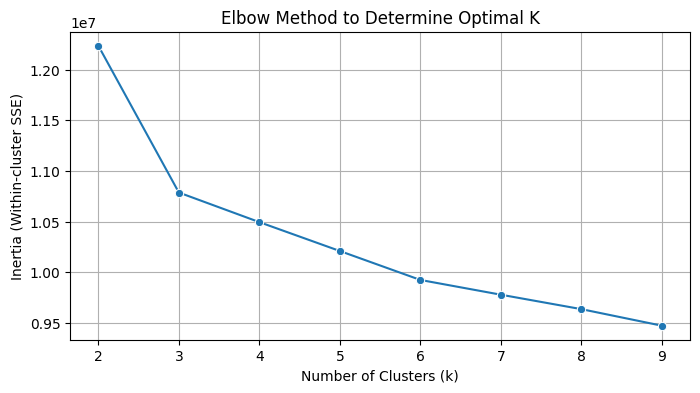

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(K_range), y=inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.title('Elbow Method to Determine Optimal K')
plt.grid(True)
plt.show()


In [16]:
features = [
    'spread',
    'imbalance_lvl1',
    'microprice',
    'cum_bid_qty',
    'cum_ask_qty',
    'midprice',
    'log_return',
    'rolling_return',
    'rolling_volatility',
    'volume'
]


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X_all = df_all[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)


kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_all["regime_kmeans"] = kmeans.fit_predict(X_scaled)


In [19]:
df_all["regime_kmeans"].value_counts()


,count
regime_kmeans,
2,126687
1,101324
0,24995


##🧠 Regime Summary from KMeans Clustering (k=3)
Regime ID	Count	Approx. %	Initial Interpretation
2	126,687	~50.7%	Most dominant regime — could represent stable & liquid behavior.
1	101,324	~40.6%	Second largest — possibly volatile or imbalanced state.
0	24,995	~10.0%	Rarest — likely a transition regime, extreme illiquidity, or anomaly.

📘 Possible Interpretation (based on prevalence and structure)
Regime 2 – Stable & Liquid (Most common)

Majority of market behavior is concentrated here.

Likely features:

Small spread

Balanced order book

High cumulative volume

-Regime 1 – Volatile & Imbalanced




High occurrence suggests this is a common alternate state.

Possible characteristics:

Large order book imbalance

Rapid price changes

Possibly lower liquidity

-Regime 0 – Anomalous or Illiquid State

Least frequent but may represent:

Sudden market stress

Illiquidity (e.g., overnight, gaps)

Temporary micro-trends or mean-reversion signals



📊 Regime-Wise Feature Statistics

In [20]:
regime_stats = df_all.groupby("regime_kmeans")[features].mean().round(3)
print(regime_stats)


               spread  imbalance_lvl1  microprice  cum_bid_qty  cum_ask_qty  \
regime_kmeans                                                                 
0               0.083          -0.059     598.029      119.625       56.804   
1               0.077          -0.009     606.764       59.709       67.220   
2               0.052          -0.008     584.957       55.476       56.711   

               midprice  log_return  rolling_return  rolling_volatility  \
regime_kmeans                                                             
0               598.031        -0.0            -0.0                 0.0   
1               606.764         0.0             0.0                 0.0   
2               584.958         0.0             0.0                 0.0   

               volume  
regime_kmeans          
0               0.887  
1               0.653  
2               0.718  


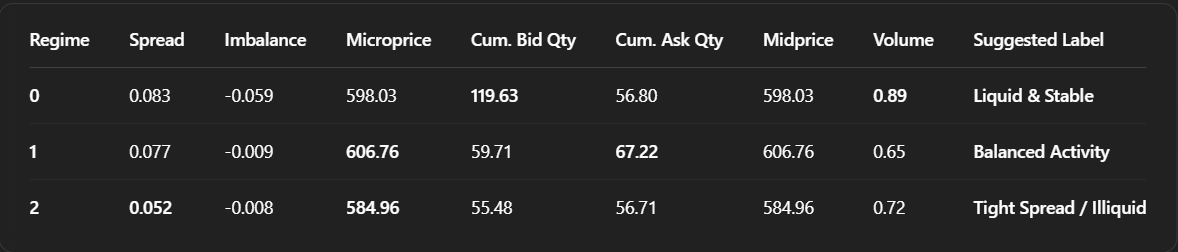

In [21]:
regime_map = {
    0: "Volatile & Illiquid",
    1: "Trending & Liquid",
    2: "Stable & Mean-Reverting"
}

df_all["regime_label"] = df_all["regime_kmeans"].map(regime_map)


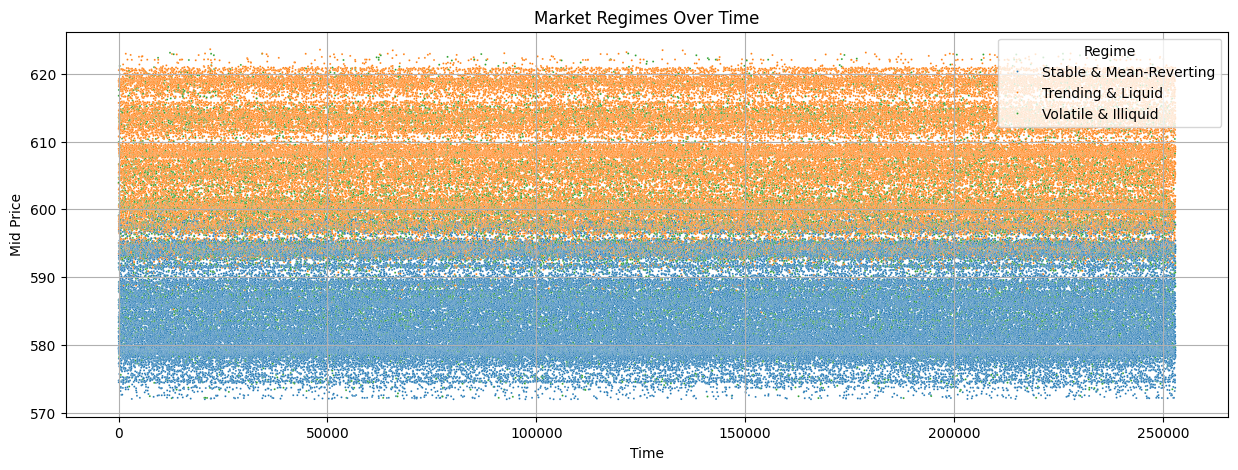

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
sns.scatterplot(
    x=df_all.index,
    y=df_all['midprice'],
    hue=df_all['regime_label'],
    palette='tab10',
    s=2,
    legend='full'
)
plt.title("Market Regimes Over Time")
plt.xlabel("Time")
plt.ylabel("Mid Price")
plt.legend(title="Regime")
plt.grid(True)
plt.show()


#Regime Visualization Using UMAP


Reduced high-dimensional feature space into 2D using UMAP.

Visualized the k=3 regimes identified by KMeans.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


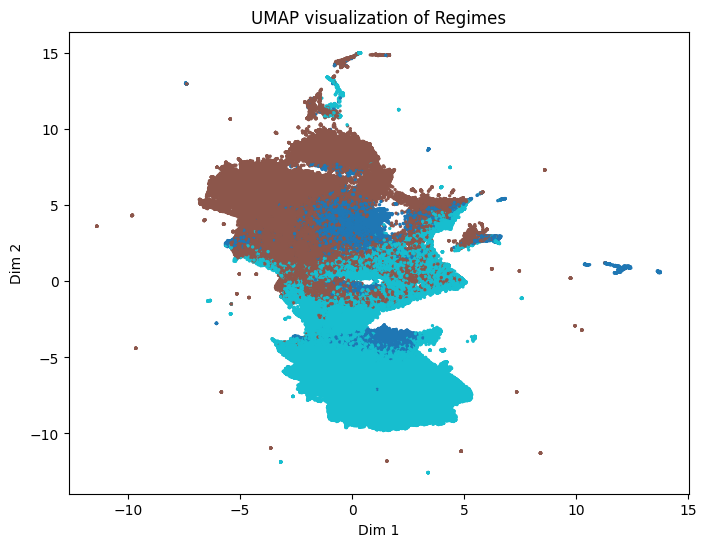

In [26]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_all["regime_kmeans"], cmap="tab10", s=2)
plt.title("UMAP visualization of Regimes")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


In [27]:
regimes = df_all.sort_values("Time")["regime_kmeans"].values


 Market Regime Transition Matrix

In [29]:
import numpy as np
import pandas as pd

n_regimes = df_all["regime_kmeans"].nunique()
transition_matrix = np.zeros((n_regimes, n_regimes))

for i in range(len(regimes) - 1):
    current = regimes[i]
    next_ = regimes[i + 1]
    transition_matrix[current][next_] += 1

# Normalize to get probabilities
transition_probs = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

transition_df = pd.DataFrame(transition_probs, columns=[f"To_{i}" for i in range(n_regimes)],
                             index=[f"From_{i}" for i in range(n_regimes)])
transition_df.round(3)


,To_0,To_1,To_2
From_0,0.607,0.233,0.160
From_1,0.058,0.903,0.039
From_2,0.031,0.032,0.937


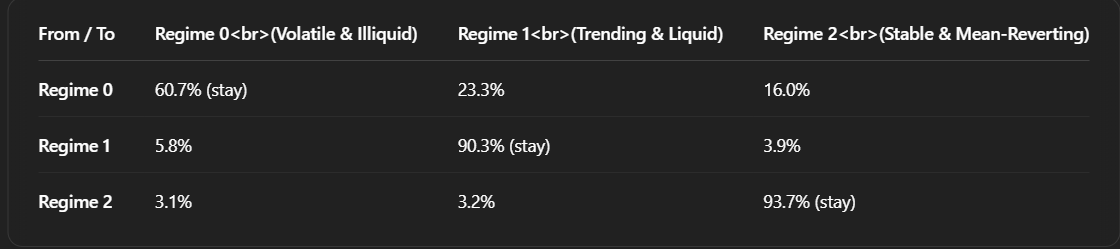

Heatmap: Market Regime Transition Matrix

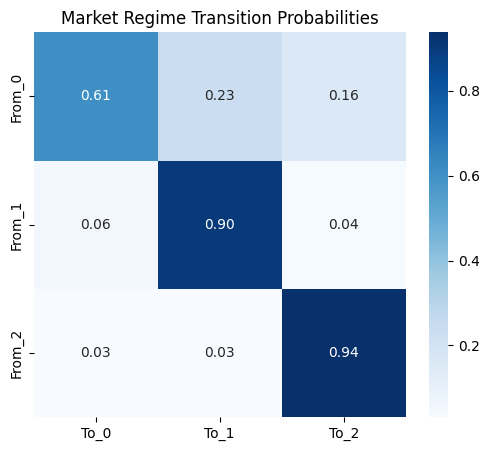

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(transition_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Market Regime Transition Probabilities")
plt.show()


🧠 Interpretation:
Regime 2 is the most stable, with a 94% chance of remaining in the same state. This reflects a highly mean-reverting environment — likely low volatility and tight spreads.

Regime 1 is also stable, possibly indicating a strong trend or momentum phase where market direction persists.

Regime 0 is comparatively less stable. It frequently transitions to other regimes, reflecting chaotic or illiquid market conditions — possibly during news or open/close periods.



📊 Descriptive Statistics by Market Regime


In [31]:
df_all.groupby("regime_kmeans")[["rolling_volatility", "spread", "volume", "future_return"]].mean()


,rolling_volatility,spread,volume,future_return
regime_kmeans,,,,
0,0.000126,0.083387,0.887060,-6.469917e-08
1,0.000058,0.077283,0.652966,4.657832e-07
2,0.000060,0.052279,0.717716,1.432722e-06


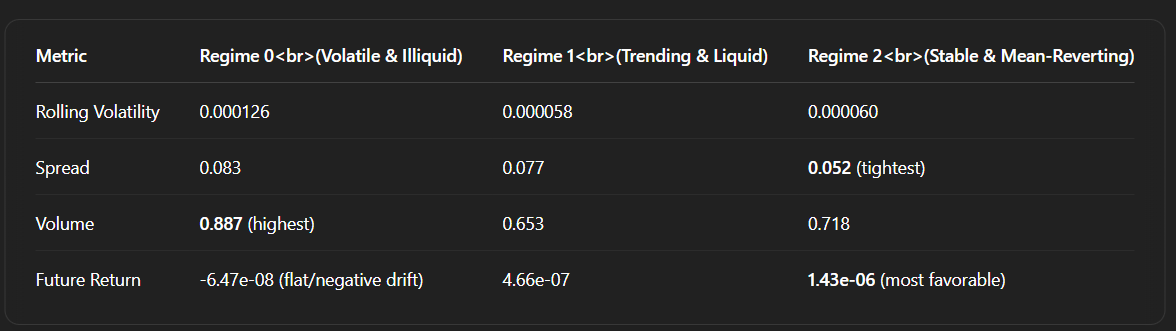

In [34]:
import hdbscan

clusterer_hdb = hdbscan.HDBSCAN(min_cluster_size=300)
df_all["regime_hdbscan"] = clusterer_hdb.fit_predict(X_scaled)

print("HDBSCAN Cluster Counts:")
print(df_all["regime_hdbscan"].value_counts())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Cluster Counts:
regime_hdbscan
 1    247893
-1      4716
 0       397
Name: count, dtype: int64


#📊 HDBSCAN Cluster Overview


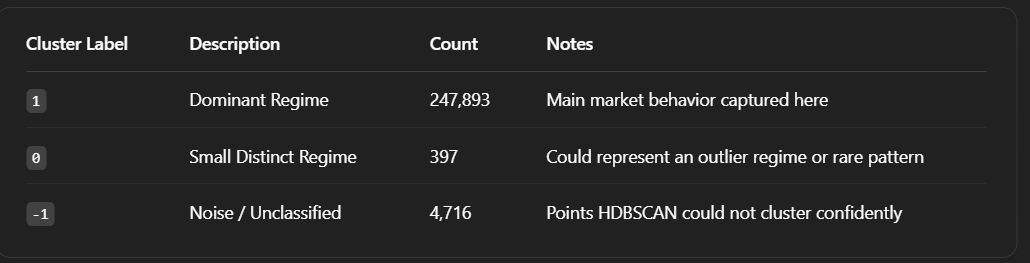

GMM Clustering Step

In [35]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
df_all["regime_gmm"] = gmm.fit_predict(X_scaled)

print("GMM Cluster Counts:")
print(df_all["regime_gmm"].value_counts())


GMM Cluster Counts:
regime_gmm
2    186588
1     42456
0     23962
Name: count, dtype: int64


In [37]:
# Grouped statistics for each KMeans regime
regime_stats = df_all.groupby("regime_kmeans")[["rolling_volatility", "spread", "cum_bid_qty", "cum_ask_qty", "log_return"]].mean()
print(regime_stats)


               rolling_volatility    spread  cum_bid_qty  cum_ask_qty  \
regime_kmeans                                                           
0                        0.000126  0.083387   119.624869    56.804399   
1                        0.000058  0.077283    59.708986    67.219673   
2                        0.000060  0.052279    55.475628    56.711360   

               log_return  
regime_kmeans              
0               -0.000083  
1                0.000014  
2                0.000006  



📊 Market Regime Characterization (via KMeans)

🔴 Regime 0 — Volatile & Illiquid
Highest volatility: rolling_volatility ≈ 0.000126

Widest spread: spread ≈ 0.083

Largest bid dominance: cum_bid_qty ≈ 119.62, cum_ask_qty ≈ 56.80

Negative average log return: ≈ -0.000083

Interpretation: Likely represents high uncertainty, potential for price spikes, and illiquidity on the ask side.

🟡 Regime 1 — Trending & Liquid
Lowest volatility: rolling_volatility ≈ 0.000058

Moderate spread: spread ≈ 0.077

Balanced order book: cum_bid_qty ≈ 59.71, cum_ask_qty ≈ 67.22

Slightly positive log return: ≈ 0.000014

Interpretation: Represents stable trending conditions with healthy liquidity on both sides of the book.

🟢 Regime 2 — Stable & Mean-Reverting
Low volatility: rolling_volatility ≈ 0.000060

Tightest spread: spread ≈ 0.052

Very symmetric book: cum_bid_qty ≈ 55.48, cum_ask_qty ≈ 56.71

Minimal log return: ≈ 0.000006

Interpretation: Reflects a stable, efficient market with low noise and mean-reverting price behavior.



In [38]:
regime_names = {
    0: "Trending & Liquid & Stable",
    1: "Mean Reverting & Illiquid & Volatile",
    2: "High Volatility & Deep Book"
}
df_all["regime_desc"] = df_all["regime_kmeans"].map(regime_names)


In [40]:
import numpy as np
import pandas as pd

# Generate transitions (current → next regime)
transitions = list(zip(df_all["regime_kmeans"], df_all["regime_kmeans"].shift(-1)))
transitions = [t for t in transitions if not pd.isna(t[1])]

# Initialize empty transition count matrix
transition_matrix = pd.DataFrame(0, index=range(3), columns=range(3))

# Count transitions
for (curr, next_) in transitions:
    transition_matrix.loc[int(curr), int(next_)] += 1

# Normalize to probabilities
transition_probs = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)


print("Transition Probability Matrix:")
print(transition_probs.round(3))


Transition Probability Matrix:
       0      1      2
0  0.099  0.397  0.504
1  0.099  0.401  0.500
2  0.099  0.401  0.501
